# Album Recommendation System

## Data Preprocessing

In [20]:
# load necessary libraries
import os
import sqlalchemy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise

from dbcv import dbcv



# load variables from .env file into set of environment variables
load_dotenv()

# get environment variables for database connection
hostname = os.getenv("HOSTNAME")
username = os.getenv("USERNAME")
password = os.getenv("PASSWORD")
database = os.getenv("DATABASE")
port = 3306

# create db connection str and MySQL engine pool
connect_str = f"mysql+pymysql://{username}:{password}@{hostname}:3306/{database}"
engine = sqlalchemy.create_engine(connect_str)

In [51]:
#album_id = 1
query_str = f"""
            SELECT Ab.title AS Title, T.valence AS Valence,
                T.danceability AS Danceability, T.energy AS Energy, T.acousticness AS Acousticness, 
                T.instrumentalness AS Instrumentalness, T.speechiness AS Speechiness, 
                T.liveness AS Liveness, T.tempo AS Tempo, T.duration AS Duration
            FROM Albums Ab
                INNER JOIN Tracks T
                    ON Ab.id=T.album_id
            WHERE Ab.num_tracks<>0;
            """
albums_df = pd.read_sql(sql=query_str, con=engine)
engine.dispose()
albums_df.head(5)

,Title,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
0,AWOL - A Way Of Life,0.576661,0.675894,0.634476,0.416675,0.010628,0.159310,0.177647,165.922,168
1,AWOL - A Way Of Life,0.269240,0.528643,0.817461,0.374408,0.001851,0.461818,0.105880,126.957,237
2,AWOL - A Way Of Life,0.621661,0.745566,0.701470,0.043567,0.000697,0.124595,0.373143,100.260,206
3,AWOL - A Way Of Life,0.894072,0.513238,0.560410,0.452217,0.019443,0.525519,0.096567,114.290,207
4,AWOL - A Way Of Life,0.800948,0.543760,0.528764,0.003596,0.000011,0.555419,0.244928,57.881,266


In [52]:
wm = lambda x: np.average(x, weights=albums_df.loc[x.index, "Duration"])
albums_df = albums_df.groupby(by="Title", as_index=True, sort=False).agg({
    "Valence":  wm,
    "Danceability":  wm,
    "Energy":  wm,
    "Acousticness":  wm,
    "Instrumentalness":  wm,
    "Speechiness":  wm,
    "Liveness":  wm,
    "Tempo":  wm,
    "Duration": "sum"
})
albums_df.head(5)					

,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
Title,,,,,,,,,
AWOL - A Way Of Life,0.645153,0.603672,0.631624,0.215582,0.005183,0.390978,0.184037,106.394892,1235
Niris,0.413890,0.640691,0.209360,0.903016,0.614020,0.041067,0.092051,83.985695,311
Constant Hitmaker,0.963590,0.658179,0.924525,0.951670,0.965427,0.032985,0.115474,111.562000,161
Every Man For Himself,0.161669,0.327551,0.404721,0.432896,0.648673,0.029080,0.178751,134.713954,478
The Blind Spot,0.609991,0.734079,0.265685,0.376312,0.669581,0.039068,0.085995,107.952000,253


In [54]:
scaler = StandardScaler()
albums_scaled = scaler.fit_transform(albums_df)
albums_scaled

array([[ 1.02891706,  0.83994085,  0.37273957, ..., -0.09120091,
        -0.67855848, -0.05631715],
       [ 0.01507331,  1.06270564, -1.26990639, ..., -0.69824261,
        -1.59210583, -0.72431953],
       [ 2.42492603,  1.16794007,  1.51215251, ..., -0.54366896,
        -0.46791294, -0.83276148],
       ...,
       [-1.31631724, -0.42706779, -1.6173449 , ..., -0.44334808,
        -1.12413905, -0.48863904],
       [ 0.30637328,  1.23622266,  0.41367934, ...,  0.70101131,
        -0.0396021 ,  1.43512107],
       [-0.9022111 ,  0.2121156 , -1.88741354, ..., -0.67241252,
        -0.12535099, -0.69901641]])

## Clustering
Here we seek to find songs that are similar to one another not simply based on distance, but following various clustering schemes which consider distance, cluster shape, and density as factors. We know little about the true underlying structure of the data, its natural groupings, generating process, and the density of those groupings. As such we use two methods which do not necessitate the pre-specification of K, the number of clusters: 1) Agglomerative clustering; 2) Density based clustering. Though, the methods still require either post-selection of K or a tuning of other hyperparameters.

### Agglomerative Clustering: Identify a Cutoff
We evaluate the Agglomerative Clustering family of models using different combinations of distance metrics and linkage methods. Based on the resulting dendrogram visualizations, we select the use of Ward's algorithm with euclidean distance, at 3 and 4 cluster cutoffs for further evaluation. 

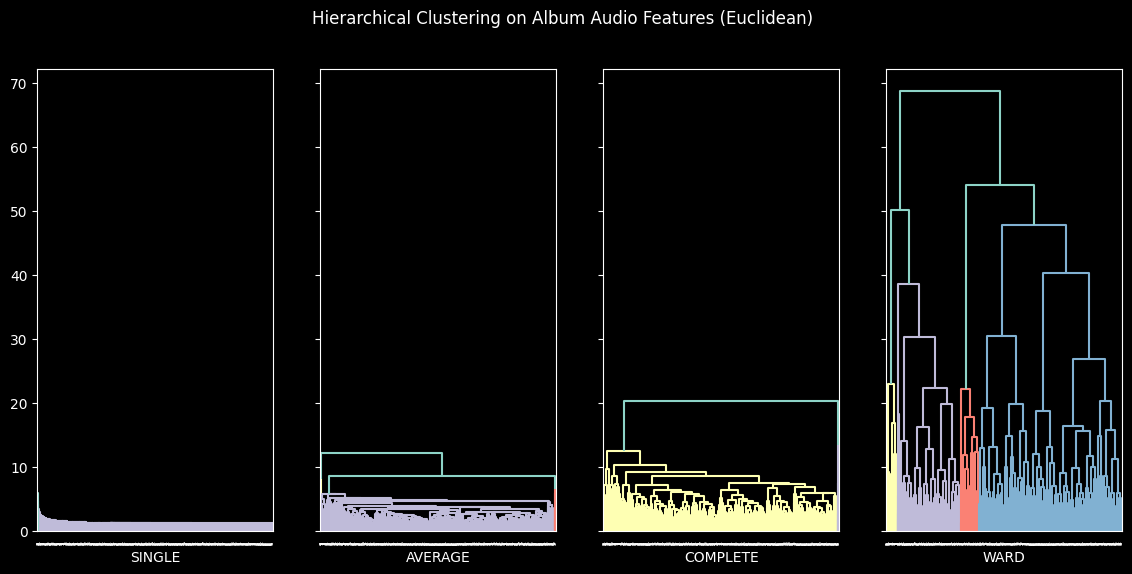

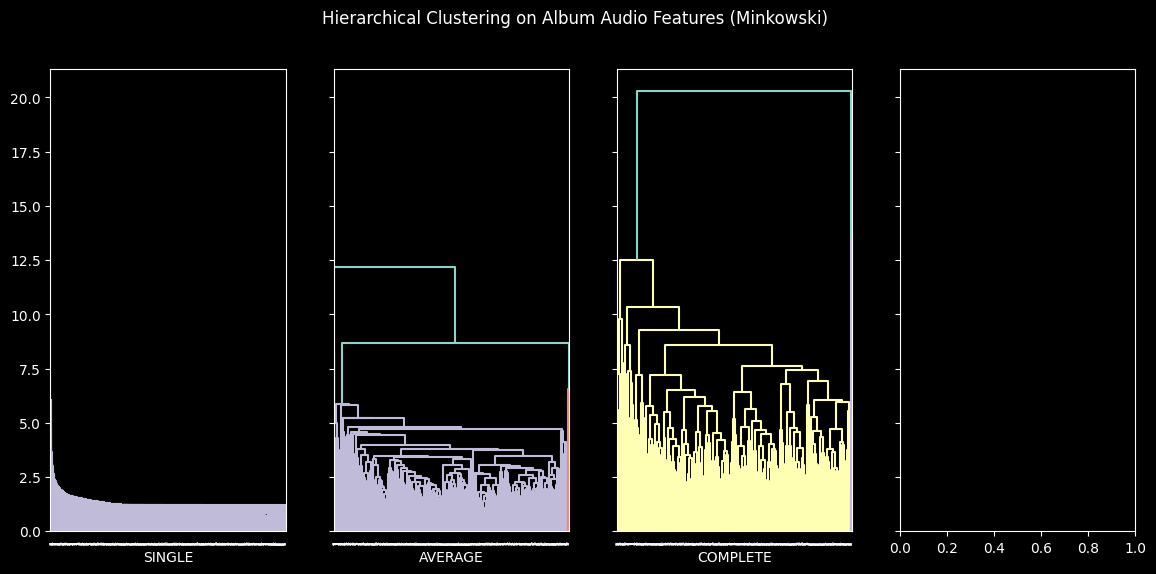

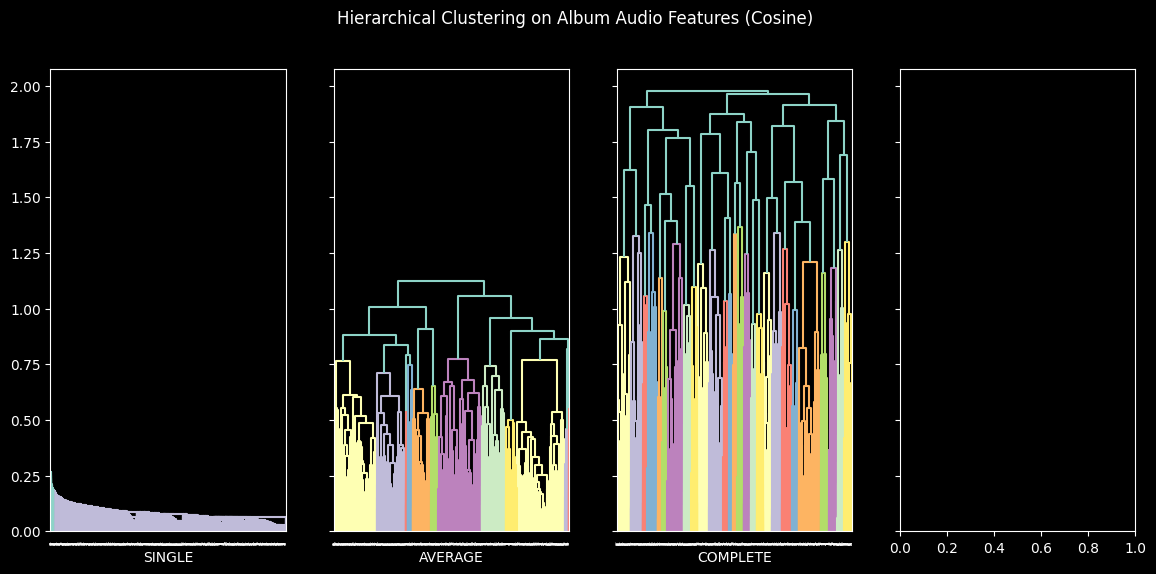

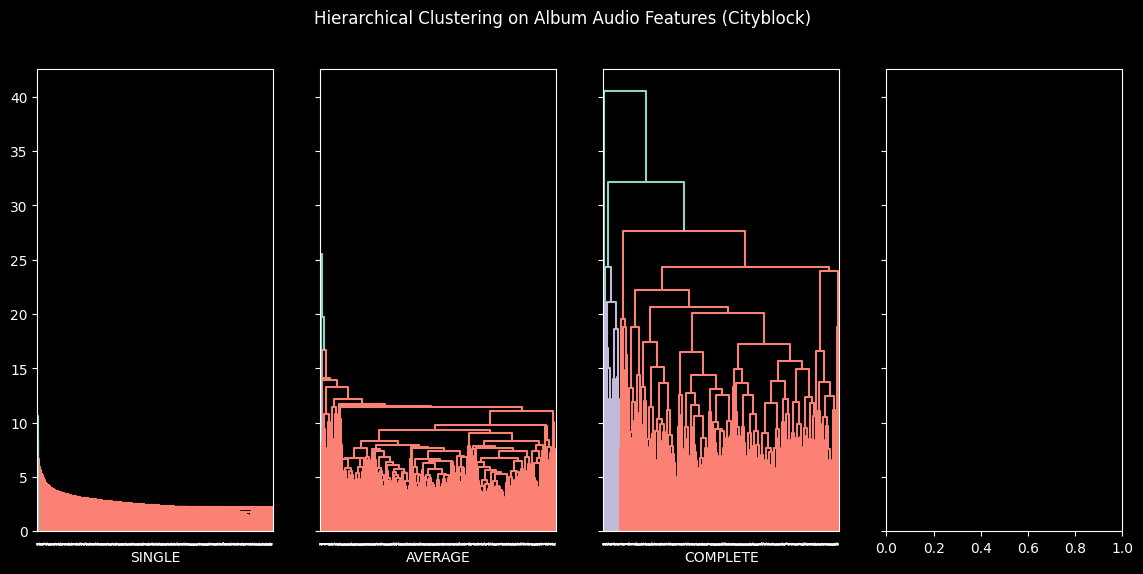

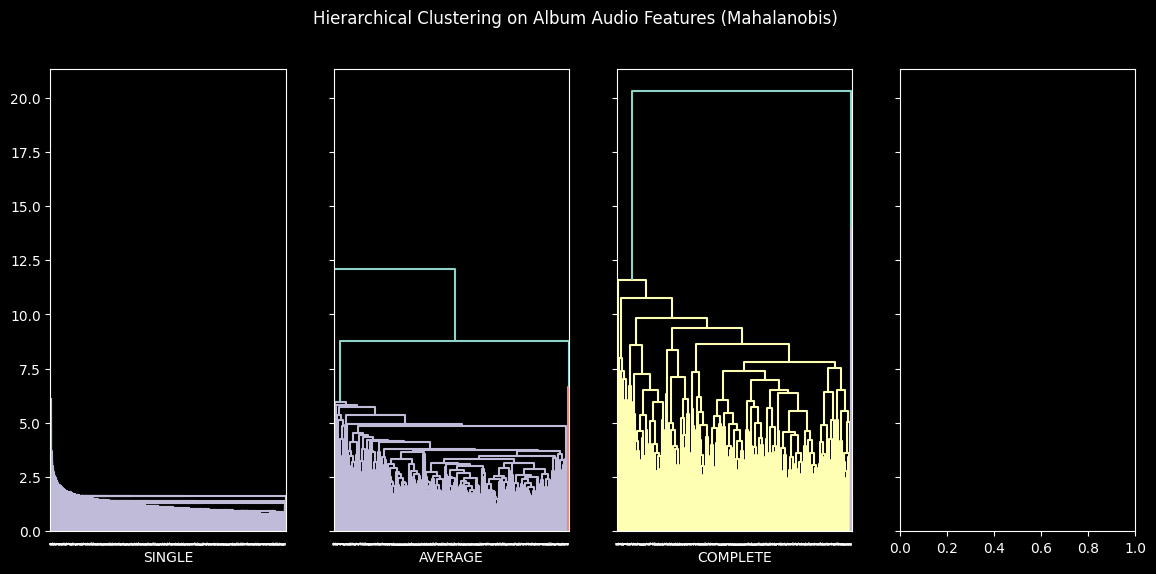

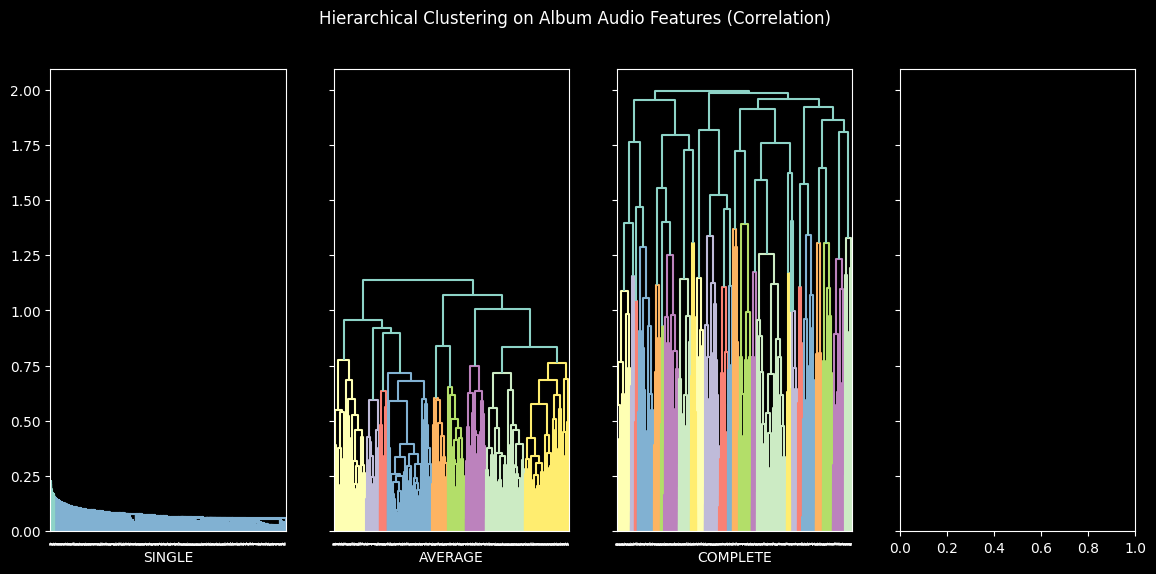

In [55]:
# assess each linkage method for each selected distance metric and visualize
distance = ["euclidean", "minkowski", "cosine", "cityblock", "mahalanobis", "correlation"]
methods = ["single", "average", "complete", "ward"]

# run hyperparameter search
for dist in distance:
    fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14,6))
    fig.suptitle(f"Hierarchical Clustering on Album Audio Features ({dist.title()})")

    for method, ax in zip(methods, axes):
        if dist != "euclidean" and method == "ward":
            continue
        Z = linkage(y=albums_scaled, method=method, metric=dist)
        ax.set_xlabel(method.upper())

        dendrogram(
            Z,
            leaf_font_size=0,
            ax=ax
        )


### Clustering & Performance assessment
* Calinski-Harabasz Index
* Silhouette scores

In [56]:
models = {
    "Agglomerative": 
    [
        {"n_clusters":3, "metric":"euclidean","linkage":"ward"},
        {"n_clusters":4, "metric":"euclidean","linkage":"ward"} 
    ],
    "Density": 
    [
        {"min_cluster_size":cluster, "min_samples":sample} 
        for cluster in range(5, 55, 5) 
        for sample in range(1, cluster+1)
    ]
}

model_eval = pd.DataFrame(
    {
        "Class": [], 
        "Hyperparams": [], 
        "Silhouette Score": [], 
        "Calinski-Harabasz Index": [],
        "Davies-Bouldin Index": [], 
        "DBCV": [],
        "Clusters": []
    }
)

model_num=0
for model in models.keys():
    print(f"Model Class '{model}' Beginning")
    for params in models[model]:
        print(f"* Hyperparam set {model_num+1}")
        # build clustering scheme
        if model == "Agglomerative":
            cluster_scheme = AgglomerativeClustering(**params)
        else:
            cluster_scheme = HDBSCAN(**params, n_jobs=-1)

        # perform clustering
        labels = cluster_scheme.fit_predict(albums_scaled)
        
        k = len(set(labels))
        if k > 1:
            # evaluate clustering scheme
            model_eval.loc[model_num,:] = [
                model, 
                params,
                silhouette_score(albums_scaled, labels), 
                calinski_harabasz_score(albums_scaled, labels),
                davies_bouldin_score(albums_scaled, labels),
                dbcv(albums_scaled, labels, n_processes=8, metric="euclidean"),
                k
            ]
                                    
            model_num+=1
    print()
        

Model Class 'Agglomerative' Beginning
* Hyperparam set 1
* Hyperparam set 2


/var/folders/2r/46yljtfx7td9ss61ym7kwqdr0000gn/T/ipykernel_31793/1244117677.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Agglomerative' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/var/folders/2r/46yljtfx7td9ss61ym7kwqdr0000gn/T/ipykernel_31793/1244117677.py:44: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{'n_clusters': 3, 'metric': 'euclidean', 'linkage': 'ward'}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.




Model Class 'Density' Beginning
* Hyperparam set 3
* Hyperparam set 4
* Hyperparam set 5
* Hyperparam set 6
* Hyperparam set 7
* Hyperparam set 8
* Hyperparam set 9
* Hyperparam set 10
* Hyperparam set 11
* Hyperparam set 12
* Hyperparam set 13
* Hyperparam set 14
* Hyperparam set 15
* Hyperparam set 16
* Hyperparam set 17
* Hyperparam set 18
* Hyperparam set 19
* Hyperparam set 20
* Hyperparam set 21
* Hyperparam set 22
* Hyperparam set 23
* Hyperparam set 24
* Hyperparam set 25
* Hyperparam set 26
* Hyperparam set 27
* Hyperparam set 28
* Hyperparam set 29
* Hyperparam set 30
* Hyperparam set 31
* Hyperparam set 31
* Hyperparam set 31
* Hyperparam set 32
* Hyperparam set 33
* Hyperparam set 34
* Hyperparam set 35
* Hyperparam set 36
* Hyperparam set 37
* Hyperparam set 38
* Hyperparam set 39
* Hyperparam set 40
* Hyperparam set 41
* Hyperparam set 42
* Hyperparam set 43
* Hyperparam set 44
* Hyperparam set 44
* Hyperparam set 44
* Hyperparam set 44
* Hyperparam set 44
* Hyperparam s

In [57]:
model_eval_summary = model_eval.drop("Hyperparams", axis=1).groupby(by=["Class", "Clusters"], as_index=False).max()
model_eval_summary

,Class,Clusters,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index,DBCV
0,Agglomerative,3.0,0.152823,263.614032,2.016149,-0.643307
1,Agglomerative,4.0,0.155944,253.736246,1.734935,-0.601456
2,Density,3.0,0.280004,79.840962,3.730731,0.496386
3,Density,4.0,0.191682,56.417552,3.145739,0.433026
4,Density,5.0,0.221475,45.730377,2.272942,0.403168
5,Density,8.0,-0.325789,17.202621,1.899054,0.040008


In [58]:
fig = make_subplots(
    rows=4, 
    cols=1, 
    specs=[[{"type":"bar"}],[{"type":"bar"}],[{"type":"bar"}], [{"type":"bar"}]],
    #subplot_titles=["Silhouette Score", "Other1", "Other2"],
    vertical_spacing=0.1
    #row_heights=[15,15,15]
)

sil = px.bar(
    data_frame=model_eval_summary,
    x="Clusters",
    y="Silhouette Score",
    color="Class",
    barmode="group",
    height=500
)
fig.add_traces(
    sil.data,
    rows=1,
    cols=1
)

chi = px.bar(
    data_frame=model_eval_summary,
    x="Clusters",
    y="Calinski-Harabasz Index",
    color="Class",
    barmode="group"
)
chi.update_traces(showlegend=False)
fig.add_traces(
    chi.data,
    rows=2,
    cols=1
)

dbi = px.bar(
    data_frame=model_eval_summary,
    x="Clusters",
    y="Davies-Bouldin Index",
    color="Class",
    barmode="group"
)
dbi.update_traces(showlegend=False)
fig.add_traces(
    dbi.data,
    rows=3,
    cols=1
)

cv = px.bar(
    data_frame=model_eval_summary,
    x="Clusters",
    y="DBCV",
    color="Class",
    barmode="group"
)
cv.update_traces(showlegend=False)
fig.add_traces(
    cv.data,
    rows=4,
    cols=1
)

fig.update_layout(height=1000, title_text="Model Evaluation")
fig.update_xaxes(title_text="Number of Clusters", row=3, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=1)
fig.update_yaxes(title_text="Calinski-Harabasz Index", row=2, col=1)
fig.update_yaxes(title_text="Davies-Bouldin Index", row=3, col=1)
fig.update_yaxes(title_text="DBCV", row=4, col=1)


fig.show()


In [59]:
# get top performing models
top_models = model_eval.loc[
    [
        model_eval.loc[model_eval.Class == "Agglomerative", "Silhouette Score"].idxmax(),
        model_eval.loc[model_eval.Class == "Density", "DBCV"].idxmax()
    ]
]

# refit clustering models based on top performing params
hiearch_mod = AgglomerativeClustering(**top_models.loc[top_models.Class == "Agglomerative", "Hyperparams"].iloc[0])
density_mod = HDBSCAN(**top_models.loc[top_models.Class == "Density", "Hyperparams"].iloc[0])

hiearch_labs = hiearch_mod.fit_predict(albums_scaled).astype(str)
density_labs = density_mod.fit_predict(albums_scaled).astype(str)

## Dimensionality Reduction/Manifold Learning for Cluster Visualization
* Isomap
* Spectral Embedding
* t-distributed Stochastic Neighborhood Embeddings (t-SNE; preserves local structure, and using init=PCA, helps preserve global structure)
* PCA

### Results of Hiearchical Clustering with Ward's Algorithm

In [60]:
# create lower dimensional representation using isomap
iso_mf_2 = Isomap(n_neighbors=200, n_jobs=-1)
iso_mf_3 = Isomap(n_components=3, n_neighbors=200, n_jobs=-1)
iso_data_2 = iso_mf_2.fit_transform(albums_scaled)
iso_data_3 = iso_mf_3.fit_transform(albums_scaled)

# create lower dimensional representation using spectral embeddings
spec_mf_2 = SpectralEmbedding()
spec_mf_3 = SpectralEmbedding(n_components=3)
spec_data_2 = spec_mf_2.fit_transform(albums_scaled)
spec_data_3 = spec_mf_3.fit_transform(albums_scaled)

# create lower dimensional representation using t-SNE
tsne_mf_2 = TSNE(perplexity=50, n_jobs=-1)
tsne_mf_3 = TSNE(**dict(n_components=3, perplexity=50), n_jobs=-1)
tsne_data_2 = tsne_mf_2.fit_transform(albums_scaled)
tsne_data_3 = tsne_mf_3.fit_transform(albums_scaled)

# create lower dimensional representation using PCA
pca_mf_2 = PCA()
pca_mf_3 = PCA(n_components=3)
pca_data_2 = pca_mf_2.fit_transform(albums_scaled)
pca_data_3 = pca_mf_3.fit_transform(albums_scaled)

In [61]:
fig = make_subplots(
    rows=2, 
    cols=2, 
    vertical_spacing=0.1,
    horizontal_spacing=.01,
    specs=[[{"type":"scatter"}, {"type":"scatter3d"}],
           [{"type":"scatter"}, {"type":"scatter3d"}]],
    subplot_titles=["Agglomerative Wards' (2 components)", "Agglomerative Wards' (3 components)", 
                    "HDBSCAN (2 components)", "HDBSCAN (3 components)"]
)

hiear_iso_2d = px.scatter(x=iso_data_2[:,0], y=iso_data_2[:,1], color=hiearch_labs)
hiear_iso_3d = px.scatter_3d(x=iso_data_3[:,0], y=iso_data_3[:,1], z=iso_data_3[:,2],color=hiearch_labs)
dense_iso_2d = px.scatter(x=iso_data_2[:,0], y=iso_data_2[:,1], color=density_labs)
dense_iso_3d = px.scatter_3d(x=iso_data_3[:,0], y=iso_data_3[:,1], z=iso_data_3[:,2],color=density_labs)

hiear_iso_2d.update_traces(marker=dict(opacity=0.5),legendgroup=1, legendgrouptitle=dict(text="Legend"))
hiear_iso_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)
dense_iso_2d.update_traces(marker=dict(opacity=0.5),legendgroup=2, legendgrouptitle=dict(text="Legend"))
dense_iso_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)

fig.add_traces(hiear_iso_2d.data,rows=1,cols=1)
fig.add_traces(hiear_iso_3d.data,rows=1,cols=2)
fig.add_traces(dense_iso_2d.data,rows=2,cols=1)
fig.add_traces(dense_iso_3d.data, rows=2,cols=2)

fig.update_layout(title_text="Isomap", height=800, legend_tracegroupgap = 250)
fig.show()

In [62]:
fig = make_subplots(
    rows=2, 
    cols=2, 
    vertical_spacing=0.1,
    horizontal_spacing=.01,
    specs=[[{"type":"scatter"}, {"type":"scatter3d"}],
           [{"type":"scatter"}, {"type":"scatter3d"}]],
    subplot_titles=["Agglomerative Wards' (2 components)", "Agglomerative Wards' (3 components)", 
                    "HDBSCAN (2 components)", "HDBSCAN (3 components)"]
)

hiear_spec_2d = px.scatter(x=spec_data_2[:,0], y=spec_data_2[:,1], color=hiearch_labs)
hiear_spec_3d = px.scatter_3d(x=spec_data_3[:,0], y=spec_data_3[:,1], z=spec_data_3[:,2], color=hiearch_labs)
dense_spec_2d = px.scatter(x=spec_data_2[:,0], y=spec_data_2[:,1], color=density_labs)
dense_spec_3d = px.scatter_3d(x=spec_data_3[:,0], y=spec_data_3[:,1], z=spec_data_3[:,2], color=density_labs)

hiear_spec_2d.update_traces(marker=dict(opacity=0.5), legendgroup=1, legendgrouptitle=dict(text="Legend"))
hiear_spec_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)
dense_spec_2d.update_traces(marker=dict(opacity=0.5), legendgroup=2, legendgrouptitle=dict(text="Legend"))
dense_spec_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)

fig.add_traces(
    hiear_spec_2d.data,
    rows=1,
    cols=1
)
fig.add_traces(
    hiear_spec_3d.data,
    rows=1,
    cols=2
)
fig.add_traces(
    dense_spec_2d.data,
    rows=2,
    cols=1
)
fig.add_traces(
    dense_spec_3d.data,
    rows=2,
    cols=2
)

fig.update_layout(title_text="Spectral Embeddings", height=800, legend_tracegroupgap = 250)
fig.show()

In [63]:
fig = make_subplots(
    rows=2, 
    cols=2, 
    vertical_spacing=0.1,
    horizontal_spacing=.01,
    specs=[[{"type":"scatter"}, {"type":"scatter3d"}],
           [{"type":"scatter"}, {"type":"scatter3d"}]],
    subplot_titles=["Agglomerative Wards' (2 components)", "Agglomerative Wards' (3 components)", 
                    "HDBSCAN (2 components)", "HDBSCAN (3 components)"]
)

hiear_tsne_2d = px.scatter(x=tsne_data_2[:,0], y=tsne_data_2[:,1], color=hiearch_labs)
hiear_tsne_3d = px.scatter_3d(x=tsne_data_3[:,0], y=tsne_data_3[:,1], z=tsne_data_3[:,2], color=hiearch_labs)
dense_tsne_2d = px.scatter(x=tsne_data_2[:,0], y=tsne_data_2[:,1], color=density_labs)
dense_tsne_3d = px.scatter_3d(x=tsne_data_3[:,0], y=tsne_data_3[:,1], z=tsne_data_3[:,2], color=density_labs)

hiear_tsne_2d.update_traces(marker=dict(opacity=0.5), legendgroup=1, legendgrouptitle=dict(text="Legend"))
hiear_tsne_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)
dense_tsne_2d.update_traces(marker=dict(opacity=0.5), legendgroup=2, legendgrouptitle=dict(text="Legend"))
dense_tsne_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)

fig.add_traces(
    hiear_tsne_2d.data,
    rows=1,
    cols=1
)
fig.add_traces(
    hiear_tsne_3d.data,
    rows=1,
    cols=2
)
fig.add_traces(
    dense_tsne_2d.data,
    rows=2,
    cols=1
)
fig.add_traces(
    dense_tsne_3d.data,
    rows=2,
    cols=2
)


fig.update_layout(title_text="t-SNE", height=800, legend_tracegroupgap = 250)
fig.show()

In [64]:
fig = make_subplots(
    rows=2, 
    cols=2, 
    vertical_spacing=0.1,
    horizontal_spacing=.01,
    specs=[[{"type":"scatter"}, {"type":"scatter3d"}],
           [{"type":"scatter"}, {"type":"scatter3d"}]],
    subplot_titles=["Agglomerative Wards' (2 components)", "Agglomerative Wards' (3 components)", 
                    "HDBSCAN (2 components)", "HDBSCAN (3 components)"]
)

hiear_pca_2d = px.scatter(x=pca_data_2[:,0], y=pca_data_2[:,1], color=hiearch_labs)
hiear_pca_3d = px.scatter_3d(x=pca_data_3[:,0], y=pca_data_3[:,1], z=pca_data_3[:,2], color=hiearch_labs)
dense_pca_2d = px.scatter(x=pca_data_2[:,0], y=pca_data_2[:,1], color=density_labs)
dense_pca_3d = px.scatter_3d(x=pca_data_3[:,0], y=pca_data_3[:,1], z=pca_data_3[:,2], color=density_labs)

hiear_pca_2d.update_traces(marker=dict(opacity=0.5), legendgroup=1, legendgrouptitle=dict(text="Legend"))
hiear_pca_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)
dense_pca_2d.update_traces(marker=dict(opacity=0.5), legendgroup=2, legendgrouptitle=dict(text="Legend"))
dense_pca_3d.update_traces(marker=dict(size=5, opacity=0.5), showlegend=False)

fig.add_traces(
    hiear_pca_2d.data,
    rows=1,
    cols=1
)
fig.add_traces(
    hiear_pca_3d.data,
    rows=1,
    cols=2
)
fig.add_traces(
    dense_pca_2d.data,
    rows=2,
    cols=1
)
fig.add_traces(
    dense_pca_3d.data,
    rows=2,
    cols=2
)

fig.update_layout(title_text="PCA", height=800, legend_tracegroupgap = 250)
fig.show()

In [65]:
clusters = pd.DataFrame(data={"Clusters": hiearch_labs}, index=albums_df.index)
cluster = clusters[clusters.Clusters==clusters.loc["AWOL - A Way Of Life", "Clusters"]]

In [74]:
in_cluster_euclidean = pairwise.euclidean_distances(
    albums_df, 
    albums_df.loc["AWOL - A Way Of Life", :].to_numpy().reshape(1,-1)
).reshape(-1,)
albums_df.iloc[np.argpartition(in_cluster_euclidean, 11)[:11], :]

,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
Title,,,,,,,,,
Negativeland,0.556546,0.562595,0.491345,0.099367,0.628842,0.084305,0.325559,106.584011,1236
Bitemarks EP,0.069888,0.462062,0.291373,0.898767,0.879909,0.053974,0.128588,118.182028,1234
Convalescence,0.178009,0.509466,0.670561,0.114558,0.387446,0.042688,0.401978,114.667541,1226
Live at WFMU on Awesome New Place with Bennett4Senate on 11/25/10,0.450134,0.524888,0.578475,0.800188,0.908999,0.033395,0.119227,111.007159,1235
AWOL - A Way Of Life,0.645153,0.603672,0.631624,0.215582,0.005183,0.390978,0.184037,106.394892,1235
Queendom Come,0.636720,0.604886,0.657979,0.227232,0.560520,0.042964,0.161265,106.180129,1230
Beethoven's Sonata No. 7 in D Major,0.188988,0.396235,0.104298,0.995513,0.954278,0.044300,0.111138,97.149182,1243
Telemetric Action EP,0.366181,0.354344,0.605053,0.452008,0.604018,0.039586,0.105924,108.694223,1244
Exotic Animals in the Scrub [LCL17],0.643852,0.698381,0.506274,0.216236,0.665011,0.149207,0.184834,109.575086,1223


In [76]:
in_cluster_cosine = pairwise.cosine_distances(
    albums_df, 
    albums_df.loc["AWOL - A Way Of Life", :].to_numpy().reshape(1,-1)
).reshape(-1,)
albums_df.iloc[np.argpartition(in_cluster_cosine, 11)[:11], :]

,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
Title,,,,,,,,,
Different World,0.259973,0.508397,0.202286,0.861484,0.241733,0.035192,0.173174,108.378872,1254
Negativeland,0.556546,0.562595,0.491345,0.099367,0.628842,0.084305,0.325559,106.584011,1236
"Live on WFMU's Three Chord Monte, Oct 7 2010",0.821487,0.466084,0.765809,0.401099,0.825609,0.036518,0.130140,129.014645,1492
Queendom Come,0.636720,0.604886,0.657979,0.227232,0.560520,0.042964,0.161265,106.180129,1230
AWOL - A Way Of Life,0.645153,0.603672,0.631624,0.215582,0.005183,0.390978,0.184037,106.394892,1235
"Live from the Purple Turtle in London on WFMU's Dark Night of the Soul with Julie June 26, 2011",0.386484,0.603534,0.701329,0.001484,0.009032,0.037405,0.214370,135.238373,1581
Live on Brian Turner's Show on 10/13/09,0.207146,0.242444,0.687271,0.734830,0.909832,0.045292,0.223521,133.468255,1548
"Live on WFMU's Dark Night of The Soul with Julie - May 9, 2013",0.411580,0.245093,0.900413,0.001856,0.550785,0.046966,0.333309,139.688673,1634
"Live on WFMU's Cherry Blossom Clinic - Feb 2, 2013",0.568231,0.351015,0.842217,0.070365,0.368178,0.047688,0.282309,129.333491,1494


In [79]:
euclid = pairwise.euclidean_distances(albums_df, albums_df.loc["AWOL - A Way Of Life", :].to_numpy().reshape(1,-1)).reshape(-1,)
albums_df.iloc[np.argpartition(euclid, 11)[:11], :]

,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
Title,,,,,,,,,
Negativeland,0.556546,0.562595,0.491345,0.099367,0.628842,0.084305,0.325559,106.584011,1236
Bitemarks EP,0.069888,0.462062,0.291373,0.898767,0.879909,0.053974,0.128588,118.182028,1234
Convalescence,0.178009,0.509466,0.670561,0.114558,0.387446,0.042688,0.401978,114.667541,1226
Live at WFMU on Awesome New Place with Bennett4Senate on 11/25/10,0.450134,0.524888,0.578475,0.800188,0.908999,0.033395,0.119227,111.007159,1235
AWOL - A Way Of Life,0.645153,0.603672,0.631624,0.215582,0.005183,0.390978,0.184037,106.394892,1235
Queendom Come,0.636720,0.604886,0.657979,0.227232,0.560520,0.042964,0.161265,106.180129,1230
Beethoven's Sonata No. 7 in D Major,0.188988,0.396235,0.104298,0.995513,0.954278,0.044300,0.111138,97.149182,1243
Telemetric Action EP,0.366181,0.354344,0.605053,0.452008,0.604018,0.039586,0.105924,108.694223,1244
Exotic Animals in the Scrub [LCL17],0.643852,0.698381,0.506274,0.216236,0.665011,0.149207,0.184834,109.575086,1223


In [80]:
cosine = pairwise.cosine_distances(albums_df, albums_df.loc["AWOL - A Way Of Life", :].to_numpy().reshape(1,-1)).reshape(-1,)
albums_df.iloc[np.argpartition(cosine, 11)[:11], :]

,Valence,Danceability,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Tempo,Duration
Title,,,,,,,,,
Different World,0.259973,0.508397,0.202286,0.861484,0.241733,0.035192,0.173174,108.378872,1254
Negativeland,0.556546,0.562595,0.491345,0.099367,0.628842,0.084305,0.325559,106.584011,1236
"Live on WFMU's Three Chord Monte, Oct 7 2010",0.821487,0.466084,0.765809,0.401099,0.825609,0.036518,0.130140,129.014645,1492
Queendom Come,0.636720,0.604886,0.657979,0.227232,0.560520,0.042964,0.161265,106.180129,1230
AWOL - A Way Of Life,0.645153,0.603672,0.631624,0.215582,0.005183,0.390978,0.184037,106.394892,1235
"Live from the Purple Turtle in London on WFMU's Dark Night of the Soul with Julie June 26, 2011",0.386484,0.603534,0.701329,0.001484,0.009032,0.037405,0.214370,135.238373,1581
Live on Brian Turner's Show on 10/13/09,0.207146,0.242444,0.687271,0.734830,0.909832,0.045292,0.223521,133.468255,1548
"Live on WFMU's Dark Night of The Soul with Julie - May 9, 2013",0.411580,0.245093,0.900413,0.001856,0.550785,0.046966,0.333309,139.688673,1634
"Live on WFMU's Cherry Blossom Clinic - Feb 2, 2013",0.568231,0.351015,0.842217,0.070365,0.368178,0.047688,0.282309,129.333491,1494
